In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv

from sksurv.column import encode_categorical
from sksurv.column import standardize
from sksurv.util import Surv

from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis


In [2]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

def evaluate_model_uno_c(model, test_X, test_y, train_y, times):
    pred = model.predict(test_X)
    uno_concordance = concordance_index_ipcw(train_y, test_y, pred, tau=times[-1])
    return uno_concordance

In [3]:
pickle_file = 'data/DATA_DECEASED_ex.pkl'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)


In [4]:
numeric_features = [
    "AGE",
    "KDPI",
    "DIALYSIS_TIME",
    "AGE_DON",
    "BMI_CALC",
    "CREAT_TRR",
    "NPKID",
    "COLD_ISCH_KI",
]
categorical_features = [
    "ON_DIALYSIS",
    "DIAB",
    "HCV_SEROSTATUS",
    "PRE_TX_TXFUS",
    "GENDER",
    "ETHCAT",
    "DIABETES_DON",
]


In [5]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Apply preprocessing to X
# X = pipeline.fit_transform(dataset[categorical_features + numeric_features ])

categorical_x = encode_categorical(dataset[categorical_features])
numerical_x = standardize(dataset[numeric_features])
X = pd.concat([numerical_x, categorical_x], axis=1)

survival_time = dataset["PTIME"].astype(np.float64)
event = dataset["PSTATUS"].astype(float).astype(bool)

y = Surv.from_arrays(event, survival_time, "Status", "Days")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y["Status"], random_state=42)

In [74]:
y_test['Status']

array([ True, False, False, ...,  True,  True,  True])

In [7]:
lower, upper = np.percentile(y["Days"], [10, 90])
times = np.arange(lower, upper + 1)

In [8]:
pickle_file = 'TrainedModels/GBSA_0.698_lr0.2_deceased_early_stopping.pkl'
# pickle_file = 'TrainedModels/FINAL_GBSA_0.698_lr0.2_deceased_early_stopping.pkl'

with open(pickle_file, 'rb') as f:
    best_model = pickle.load(f)

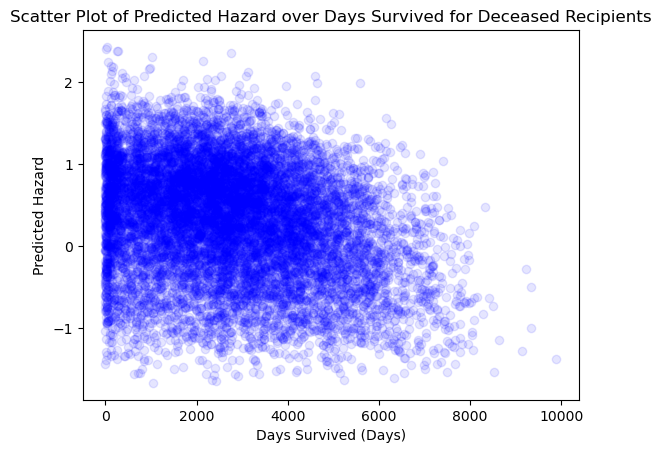

In [14]:
import matplotlib.pyplot as plt

prediction = best_model.predict(X_test)

true_data = y_test[y_test['Status']]

# Extract the "Days" and "Prediction" values from the filtered data
days_true = true_data['Days']
prediction_true = prediction[y_test['Status']]

# Plot the filtered data
plt.scatter(days_true, prediction_true, color='blue', alpha=0.1)
plt.xlabel('Days Survived (Days)')
plt.ylabel('Predicted Hazard')
plt.title('Scatter Plot of Predicted Hazard over Days Survived for Deceased Recipients')
path = "../Thesis/Images/Results/"
plt.savefig(path + "scoring.pdf", bbox_inches="tight")
plt.show()

In [15]:
import numpy as np

correlation = np.corrcoef(days_true, prediction_true)[0, 1]
correlation

-0.2705927508528431

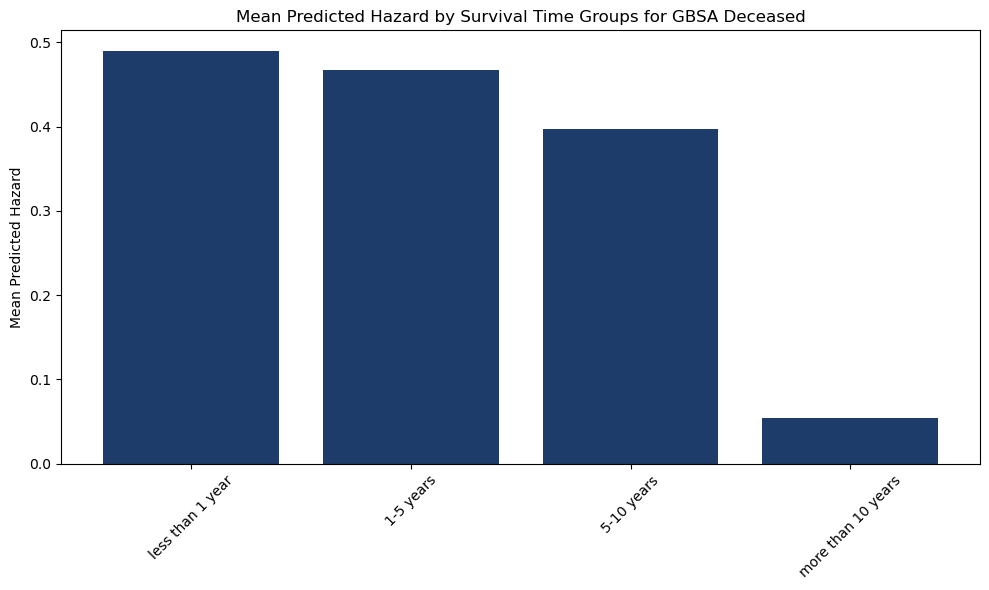

In [22]:
import numpy as np
import matplotlib.pyplot as plt

prediction = best_model.predict(X_test)

true_data = y_test[y_test['Status']]

days_true = true_data['Days']
prediction_true = prediction[y_test['Status']]

groups = {
    "less than 1 year": (0, 365),
    "1-5 years": (365, 1825),
    "5-10 years": (1825, 3650),
    "more than 10 years": (3650, 10000),
}

group_means = {}
for group_name, (start, end) in groups.items():
    mask = (days_true >= start) & (days_true < end)
    group_predictions = prediction_true[mask]
    group_means[group_name] = np.mean(group_predictions) if len(group_predictions) > 0 else np.nan

plt.figure(figsize=(10, 6))
group_names = list(group_means.keys())
mean_values = [group_means[group] for group in group_names]

plt.bar(group_names, mean_values, color="#052759",alpha=0.9)
plt.ylabel('Mean Predicted Hazard')
plt.title('Mean Predicted Hazard by Survival Time Groups for GBSA Deceased')
plt.xticks(rotation=45)
plt.tight_layout()

path = "../Thesis/Images/Results/"
plt.savefig(path + "scoring_by_group.pdf", bbox_inches="tight")
plt.show()


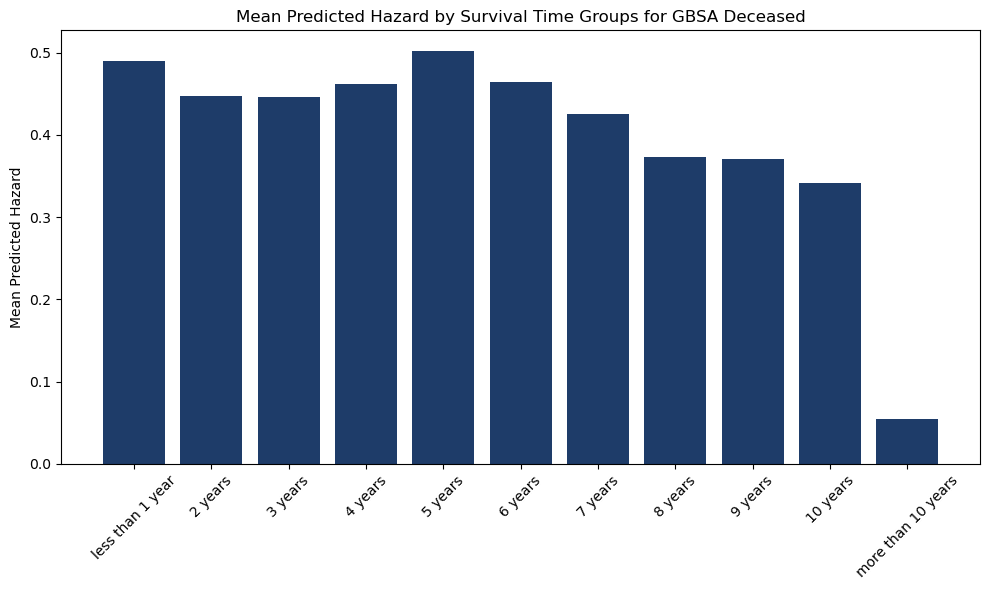

In [20]:
import numpy as np
import matplotlib.pyplot as plt

prediction = best_model.predict(X_test)

true_data = y_test[y_test['Status']]

days_true = true_data['Days']
prediction_true = prediction[y_test['Status']]

groups = {
    "less than 1 year": (0, 365),
    "2 years": (365, 730),
    "3 years": (730, 1095),
    "4 years": (1095, 1460),
    "5 years": (1460, 1825),
    "6 years": (1825, 2190),
    "7 years": (2190, 2555),
    "8 years": (2555, 2920),
    "9 years": (2920, 3285),
    "10 years": (3285, 3650),
    "more than 10 years": (3650, 10000),
}

group_means = {}
for group_name, (start, end) in groups.items():
    mask = (days_true >= start) & (days_true < end)
    group_predictions = prediction_true[mask]
    group_means[group_name] = np.mean(group_predictions) if len(group_predictions) > 0 else np.nan

plt.figure(figsize=(10, 6))
group_names = list(group_means.keys())
mean_values = [group_means[group] for group in group_names]

plt.bar(group_names, mean_values, color="#052759", alpha=0.9)
plt.ylabel('Mean Predicted Hazard')
plt.title('Mean Predicted Hazard by Survival Time Groups for GBSA Deceased')
plt.xticks(rotation=45)
plt.tight_layout()

path = "../Thesis/Images/Results/"
plt.savefig(path + "scoring_by_year_group.pdf", bbox_inches="tight")
plt.show()


In [46]:
def print_stat(prediction):
    print("Hazard")
    print('count', len(prediction))
    print("max: ", prediction.max())
    print("min: ", prediction.min())
    print("mean: ", prediction.mean())
    print("std: ", prediction.std())

def get_stat(prediction):
    return prediction.max(), prediction.min(), prediction.mean(), prediction.std()

In [31]:
get_stat(prediction)

Hazard
count 23508
max:  2.43066976534782
min:  -1.8478071868681945
mean:  0.0015767035718241707
std:  0.7559664242918054


## The Scoring Implementation

In [69]:
from scipy.stats import norm

def calculate_transplant_score(predicted_hazard, age):
    hazard_max, hazard_min, _, _ = get_stat(prediction)

    n_hazard = 1 - (predicted_hazard - hazard_min) / (hazard_max 2- hazard_min)

    min_age, max_age = 18, 80
    if age <= min_age:
        n_age = 1
    elif age >= max_age:
        n_age = 0
    else:
        n_age = 1 - (age - min_age) / (max_age - min_age)
    
    score = 100 * (0.5 * n_hazard + 0.5 * n_age)
    return score

# example usage
predicted_hazard = -1
age = 40
score = calculate_transplant_score(predicted_hazard, age)
print(f"Transplant Score: {score:.2f}")


Transplant Score: 72.35


In [83]:
import pandas as pd

Y_happened = y_test[y_test['Status']==True]
X_happened = X_test[y_test['Status']==True]

prediction_score = best_model.predict(X_happened)

df_prediction = pd.DataFrame({'Predicted Hazard': prediction_score[:10], 
                              'Score': [calculate_transplant_score(hazard, age) for hazard in prediction_score[:10]],
                              'Survival': Y_happened['Days'][:10]
                              })

latex_table = df_prediction.to_latex(index=False)

print(latex_table)

\begin{tabular}{rrr}
\toprule
 Predicted Hazard &      Score &  Survival \\
\midrule
        -0.854124 &  67.079316 &    2113.0 \\
         0.203719 &  41.642521 &    5537.0 \\
         0.593991 &  32.258065 &    2513.0 \\
        -0.979759 &  70.100331 &     964.0 \\
        -0.344581 &  54.826901 &    4793.0 \\
         0.258669 &  40.321190 &    1428.0 \\
         0.058312 &  45.138960 &    5561.0 \\
        -1.074110 &  72.369084 &    2142.0 \\
         1.313032 &  14.968083 &       2.0 \\
        -1.266887 &  77.004577 &    2685.0 \\
\bottomrule
\end{tabular}

